# Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

### Imports

In [2]:
import pandas as pd; import seaborn as sb; import warnings; import scipy; import re; 
import os; from analysis_helpers import *; import itertools; from scipy import stats
import random; import pandas as pd; import numpy as np; from sklearn import datasets, linear_model; 
from sklearn.linear_model import LinearRegression; import statsmodels.api as sm
from scipy import stats; from itertools import groupby; from operator import itemgetter; import pingouin
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Behavioral Data

In [3]:
# data = pd.read_csv('../parsed_data/FULL_DATA.csv')
data = pd.read_csv('../parsed_data/full_behavioral.csv')

## Organize Behavioral


### Add cued category from last presentation trial to memory blocks

In [4]:
# for each memory trial, add which category was last cued before that memory trial began

# for each participant
for s in data['UniqueID'].unique():
    
    # for each run of that participant's data
    for r in data['Run'].unique():
        
        # select the memory trials for that participant for that run
        # set Last Cued for Memory trials of this run equal to:
        # the Cued Category in the last presentation trial of the run (Trial #9) 
        data.loc[(data['Run']==r) 
                 & (data['UniqueID']==s) 
                 & (data['Trial Type']=='Memory'), 'Last Cued'] = data[(data['Run']==r) & (data['UniqueID']==s) & (data['Trial Type']=='Presentation') & (data['Trial']==9)]['Cued Category'].item()
        
# make a copy of the data where novel images labeled by whether they are in the last-cued image category

# data_nov = copy of the original data where Novel images are not distinguished from each other
data_nov = data

# use the add_nov_labels function to label the Novel images Cued_Novel or Uncued_Novel
# data = dataframe with labeled novel images
data     = add_nov_label(data, column_name = 'Last Cued')

# Statistics

Below are all of the statistical tests done on the behavioral data, roughly in the order they appear in the paper

### Reaction Time Stats (Cued vs. Uncued side)

In [5]:
# make sure sides are corrected exp2 group1

In [6]:
# compare average attention probe reaction times (valid versus invalid)

# group experiment data by UniqueID, Cue Validity, and Experiment
data_gr = data.groupby(['UniqueID','Cue Validity', 'Experiment'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    # select data for that exp only
    dat = data_gr[(data_gr['Experiment']== experiment)]

    print('exp : '+ experiment)
    
    # conduct paired t-test on participants' average reaction times to valid versus invalid probes
    print(scipy.stats.ttest_rel(dat[dat['Cue Validity']==1]['Attention Reaction Time (s)'], 
                                dat[dat['Cue Validity']==0]['Attention Reaction Time (s)']))

    print()

#         print(cohen_d(list(data_gr[(data_gr['Cue Validity']==1) & (data_gr['Experiment'] == experiment)]['Attention Reaction Time (s)']),
#                       list(data_gr[(data_gr['Cue Validity']==0) & (data_gr['Experiment'] == experiment)]['Attention Reaction Time (s)'])))

exp : /sustain
Ttest_relResult(statistic=-1.3116726292708842, pvalue=0.19471185389722823)

exp : /variabl
Ttest_relResult(statistic=-0.6498755354162346, pvalue=0.5186333715346416)



# Calculate Differences

In [7]:
# make empty dictionary, diffs
diffs = {}

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    # make a key in the diffs dictionary for this experiment
    diffs[experiment] = []
    
    # select the data for this experiment only
    d = data_gr[(data_gr['Experiment']== experiment)]

    # for each participant in the experiment
    for s in d['Subject'].unique():
        
        # calculate participant's average reaction time to valid and invalid probes
        cued   = d[(d['Subject']==s)&(d['Cue Validity']==0)]['Attention Reaction Time (s)'].mean()
        uncued = d[(d['Subject']==s)&(d['Cue Validity']==1)]['Attention Reaction Time (s)'].mean()

        # obtain the difference in their mean RT to cued versus uncued probes ( cued - uncued )
        # append this difference value to this experiment's key in the diffs dictionary
        diffs[experiment].append(cued - uncued)

# conduct an independent t-test comparing RT differences in each experiment
print('RT Diff Comparison')
print(scipy.stats.ttest_ind(diffs['/sustain'], diffs['/variabl']))

#print(cohen_d(diffs['/sustain'], diffs['/variabl']))

RT Diff Comparison
Ttest_indResult(statistic=0.9989873228412799, pvalue=0.3211464555384016)


### Compare Fully Attended images to all other images

In [8]:
# compare average ratings for fully attended images to all other image types 

for experiment in ['/sustain', '/variabl']:
# for each experiment

    # make empty lists Fulls and Others
    Fulls  = []
    Others = []

    # for each participant in this experiment
    for s in data[(data['Experiment']==experiment)]['UniqueID'].unique():

        # append participant's average Familiarity Rating for Fully attended images to Fulls list
        Fulls.append(data[(data['UniqueID']==s)&(data['Attention Level']=='Full') & (data['Experiment']==experiment)]['Familiarity Rating'].mean())
        # append participant's average Familiarity Rating for all other images (Category, Side, None, Novel_Cued, Novel_Uncued) to Others
        Others.append(data[(data['UniqueID']==s)&(data['Attention Level']!='Full') & (data['Experiment']==experiment)]['Familiarity Rating'].mean())

    # conduct paired t-test comparing Fully attended image ratings to ratings for all other images
    print()
    print('experiment : '+experiment)
    print(scipy.stats.ttest_rel(Fulls, Others))
    print()
        


experiment : /sustain
Ttest_relResult(statistic=13.421183052640375, pvalue=1.3945182924068942e-19)


experiment : /variabl
Ttest_relResult(statistic=12.405867076386683, pvalue=3.6567724184869514e-17)



### Face versus Scene

In [9]:
# compare ratings for fully attended scenes with ratings for fully attended faves

# group data by participant, experiment, attn level, and image category (face or place)
f_p = data.groupby(['UniqueID', 'Experiment', 'Attention Level', 'Category'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
        print()

        print('experiment : '+experiment)

        # conduct a paired t-test comparing Familiarity Ratings for Fully attended Place images and Fully attended Face images
        print(scipy.stats.ttest_rel(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full') 
                                        & (f_p['Experiment']==experiment)]['Familiarity Rating'], 

                                    f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full') 
                                        & (f_p['Experiment']==experiment)]['Familiarity Rating']))

        print ()
    
            
#             print(cohen_d(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full')& (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating'], 
#                                 f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full')& (f_p['Experiment']==experiment) & (f_p['Group']==group)]['Familiarity Rating']))
#             print()


          


experiment : /sustain
Ttest_relResult(statistic=7.687873877550006, pvalue=1.8473338043613615e-10)


experiment : /variabl
Ttest_relResult(statistic=7.085593793199018, pvalue=3.6138893528986493e-09)



### Attended Category versus Unattended

In [10]:
# group data by participant, experiment, and attn level
d = data.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
    # make empty lists Cats and Nones
    Cats  = []
    Nones = []

    # for each participant in this experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():

        # append participant's average Familiarity Rating for Category attended images to Cats list
        Cats.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Category']) & (d['Experiment']==experiment))]['Familiarity Rating'].mean())
        # append participant's average Familiarity Rating for None attended images to Nones list
        Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean())

    # conduct a paired t-test comparing average rating of Category attention level images and None attention level images
    print('experiment : '+experiment)
    print(scipy.stats.ttest_rel(Cats, Nones))
    #print(cohen_d(Cats, Nones))
    print()

experiment : /sustain
Ttest_relResult(statistic=7.169020123474894, pvalue=1.399590794698868e-09)

experiment : /variabl
Ttest_relResult(statistic=0.4310799396268719, pvalue=0.6681920627291599)



### Attended Side vs Unattended

In [11]:
# group data by UniqueID, Experiment, Attention Level
d = data.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment 
for experiment in ['/sustain', '/variabl']:
    
    # make empty lists Sides and Nones    
    Sides  = []
    Nones = []
    
    # for each participant in the select experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():

        # append participant's average Familiarity Rating for Side attended images to Sides list
        Sides.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Side'])) & (d['Experiment']==experiment)]['Familiarity Rating'].mean())
        # append participant's average Familiarity Rating for None attended images to Nones list
        Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean())

    # conduct paired t-test between average ratings for Side attended and None attended images
    print(scipy.stats.ttest_rel(Sides, Nones))
    print()

Ttest_relResult(statistic=4.320885072719229, pvalue=6.048927164309282e-05)

Ttest_relResult(statistic=2.5918457744677217, pvalue=0.012363373090488588)



In [12]:
# sustained attention experiment

# sb.barplot(data=data[data['Experiment']=='/sustain'], x='Attention Level', y='Familiarity Rating', hue='Group',
#           order=['Full','Category','Nov_Cued','Side','None','Nov_Un'])

In [13]:
# variable attention experiment

# sb.barplot(data=data[data['Experiment']=='/variabl'], x='Attention Level', y='Familiarity Rating', hue='Group',
#           order=['Full','Category','Nov_Cued','Side','None','Nov_Un'])

### Cued versus Uncued Novel images

In [14]:
# group data by UniqueID, Experiment, Attention Level
d = data.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    # obtain familiarity ratings for Nov_Cued and Nov_Un images
    a = d[(d['Attention Level']=='Nov_Cued') & (d['Experiment']==experiment)]['Familiarity Rating']
    b = d[(d['Attention Level']=='Nov_Un') & (d['Experiment']==experiment)]['Familiarity Rating']

    # conduct a paired t-test comparing average ratings for Nov_Cued and Nov_Un images
    print(experiment)
    print(scipy.stats.ttest_rel(a, b))

    # print(cohen_d(a, b))
    print()
    

/sustain
Ttest_relResult(statistic=7.036354379522863, pvalue=2.347940343678428e-09)

/variabl
Ttest_relResult(statistic=0.22623974901616303, pvalue=0.8219019101538758)



### Feature boost versus feature bias boost

In [15]:
# group data by participant, experiment, attention level
d = data.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
    # make empty lists cat_no and nov_diff
    cat_no   = []
    nov_diff = []

    # for each participant in the select experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():
        
        # obtain average familiarity rating for images in the cued category (Category attended or Full attended)
        cat = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Category', 'Full']))& (d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average familiarity rating for None attended images
        no = d[(d['UniqueID']==s) &(d['Attention Level']=='None')& (d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average familiarity ratings for novel images in the cued category 
        nov_c = d[(d['UniqueID']==s) &(d['Attention Level']=='Nov_Cued')& (d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average familiarity ratings for novel images in the uncued category 
        nov_u = d[(d['UniqueID']==s) &(d['Attention Level']=='Nov_Un')& (d['Experiment']==experiment)]['Familiarity Rating'].mean()

        # find the difference between cued-cat images (Full or Category) and None attended images
        # append to cat_no list
        cat_no.append(cat - no)
        
        # find the difference between cued novel and uncued novel images
        # append to the nov_diff list
        nov_diff.append(nov_c - nov_u)

    # conduct a paired t-test
    print('experiment : '+experiment)
    print(scipy.stats.ttest_rel(cat_no, nov_diff))
    #print(cohen_d(cat_no, nov_diff))
    print()


experiment : /sustain
Ttest_relResult(statistic=7.5921023640084675, pvalue=2.684431943887523e-10)

experiment : /variabl
Ttest_relResult(statistic=6.754379920812893, pvalue=1.2195013022420481e-08)



### Feature boost versus Location boost

In [16]:
# SHOWN BELOW:

# mean(Cat & Full) - mean(None)
# versus
# mean(Side & Full) - mean(None)

# -------------------------------
# NOT YET REPLICATED IN NEW DATA:

# Experiment 1: ( (mean(Cat & Full) - mean(None))  -    (mean(Side & Full) - mean(None)) )    
# versus
# Experiment 2: ( (mean(Cat & Full) - mean(None))   -    (mean(Side & Full) - mean(None)) )    

In [17]:
# group data by participant, experiment, attention level
d = data.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# make empty dictionaries (full, diffs, and side_diffs)
full = {}; diffs = {}; side_diffs = {}

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
    # set label equal to experiment name
    label = experiment 

    # make empty lists cat_nov and side_nov
    cat_nov  = []
    side_nov = []

    # for each participant in this experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():
        
        # obtain average ratings for images that were presented on the attended side (Side attended or Full attended)
        side = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Side','Full'])) & (d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average ratings for images that were in the attended caategory (Category attended or Full attended)
        cat  = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Category', 'Full'])) & (d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average familiarity ratings for images that were None attended
        nov  = d[(d['UniqueID']==s)&(d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean()

        # obtain the difference between cat-attended and none-attended
        cat_nov.append(cat - nov)
        
        # obtain the difference between side-attended and non-attended
        side_nov.append(side - nov)

    # conduct paired t-test comparing cat and none differences with side and none differences
    print()
    print('experiment : '+experiment)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print()
    
    # calculate the difference between cat_none differences and side_none differences 
    diff = [x-y for x,y in zip(cat_nov, side_nov)]
    
    # add the difference values between cat_none diffs and side_non diffs to diffs dictionary
    # add to the key for this experiment
    diffs[label] = diff
    
    # add the side_none differences to the side_diff dictionary in a key for this experiment
    side_diffs[label] = side_nov
    

# conduct an independent t-test comparing cat_none and side_none differences from the two experiments
print()
print('Feature boost relative to Location boost, Exp1 vs Exp 2')
print(scipy.stats.ttest_ind(diffs['/sustain'], diffs['/variabl']))
# print(cohen_d(diffs['/sustain'], diffs['/variabl']))

# conduct an independent t-test comparing side_none differences from the two experiments
print()
print('Location boost relative to none, Exp2 vs Exp1')
print(scipy.stats.ttest_ind(side_diffs['/sustain'], side_diffs['/variabl']))
# print(cohen_d(side_diffs['/sustain'], side_diffs['/variabl']))


experiment : /sustain
Ttest_relResult(statistic=3.2490949771808535, pvalue=0.0019134206193149516)


experiment : /variabl
Ttest_relResult(statistic=-1.699901820938161, pvalue=0.09512430967613025)


Feature boost relative to Location boost, Exp1 vs Exp 2
Ttest_indResult(statistic=3.4948830288803245, pvalue=0.0006825668408073697)

Location boost relative to none, Exp2 vs Exp1
Ttest_indResult(statistic=2.29929613013857, pvalue=0.02335909948222869)


### Fully Attended versus Side Attended boost

In [18]:
# group the data by participant, experiment, attention level
d = data.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# make empty dictionary, full
full = {}

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
    # set label equal to experiment name
    label = experiment 

    # make empty lists 
    cat_nov  = []
    side_nov = []

    # for each participant
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():

        # obtain average rating for Side attended images
        side = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Side']))&(d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average rating for Full attended images
        cat  = d[(d['UniqueID']==s)&(d['Attention Level'].isin(['Full']))&(d['Experiment']==experiment)]['Familiarity Rating'].mean()
        
        # obtain average rating for None attended images
        nov  = d[(d['UniqueID']==s)&(d['Attention Level']=='None')&(d['Experiment']==experiment)]['Familiarity Rating'].mean()

        # obtain difference between average ratings for Full attended and None attended images
        cat_nov.append(cat - nov)
        
        # obtain differece between average ratings for Side attended and None attended images
        side_nov.append(side - nov)

    # conduct paired t-test for cat-none differences and side-none differences
    print('experiment : '+experiment)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    # print(cohen_d(cat_nov, side_nov))
    print()

experiment : /sustain
Ttest_relResult(statistic=9.501823182090353, pvalue=1.682767549974878e-13)

experiment : /variabl
Ttest_relResult(statistic=9.721600586854604, pvalue=2.730856909179824e-13)



# Plot Data

In [19]:
#data_original.groupby(['Attention Level']).count()

## Violin Plots 

In [20]:
# data original is the data
data_original = data

/sustain: Average Familiarity by Attention Level


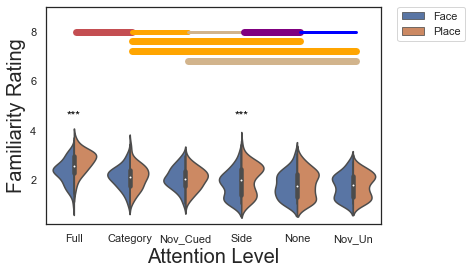

/variabl: Average Familiarity by Attention Level


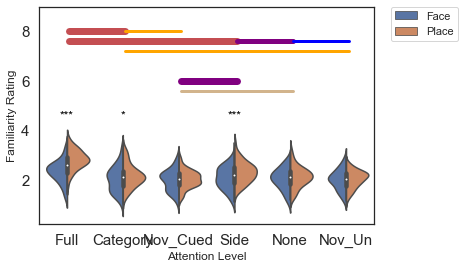

In [21]:
# PLOT PARAMS
snoop = 0
stat_dict_full = {'/sustain':{}, '/variabl':{}}

# color list 
col = ['r','orange','tan','purple','blue','grey']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']

# plot settings
sb.set_style("white")
plt.grid(False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Attention Level',    fontsize = 20)
plt.ylabel('Familiarity Rating', fontsize = 20)


# for each experiment, for each test group, group and plot

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    # set label equal to experiment
    label = experiment 

    # select data for this experiment
    d = data_original[(data_original['Experiment']==experiment)]


    # VIOLIN PLOT
    
    # group data by participant, attention level, category (face or place)
    data = d.groupby(['UniqueID','Attention Level', 'Category'], as_index = False).mean()
    
    print(label + ': Average Familiarity by Attention Level')
    
    # plot data: x-axis - attention level; y-axis - rating; hue - category (facae or place)
    sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data, split=True, hue='Category', 
                 order=cats)
    
    sb_plot.set(ylim=(.2, 9))
    
    ax1 = sb_plot.axes

    
    ###################################
    ### SIGNIFICANCE STARS FOR PLOTTING ###
    
    # make empty dictionary, t_draw
    t_draw = {}
    
    # for each attention level
    for c in data['Attention Level'].unique():
        
        # get the familiarity ratings for Face images at this attention level
        first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
        
        # get the familiarity ratings for Place images at this attention level
        second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])
        
        # we want to do a paired t-test between average ratings for Place and Face images attended at each level
        # however, in the variable attention experiment, there may be participants who always had the same last-cued category
        # (because category cues are given in a random order)
        
        if len(first) == len(second):

            # conduct a paired t-test between familiarity ratings for Face and Place images attended at that level
            t = scipy.stats.ttest_rel(first, second)
            
        elif len(first) != len(second):
            
            # conduct an independent t-test between familiarity ratings for Face and Place images attended at that level
            t = scipy.stats.ttest_ind(first, second)

        # apply symbol appropriate to the significance level
        if t[1]<.001:
            t_draw[c] = '***'
        
        elif t[1]<.01:
            t_draw[c] = '**'

        elif t[1]<.05:
            t_draw[c] = '*'

        elif t[1]<.0551:
            t_draw[c] = '+'

###################################


    ### SIGNIFICANCE BETWEEN VIOLINS FOR PLOTTING ###
    
    # make empty dictionary for this experiment, stat_dict
    stat_dict = {}
    
    # group data by participant, attention level
    k = data.groupby(['UniqueID','Attention Level'],as_index=False).mean()

    # use itertools to make a tuple for every possible attention level combination (Full & Side, None & Category, etc)
    # for each tuple (eacah attention level pair)
    for pair in list(itertools.combinations(cats, r=2)):
        
        # conduct a pairerd t-test between the ratings for that attention level
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])
        
        # add the t-stat and p-value from the test to the stat_dict_full dict for this experiment
        # within this experiment dict, add it to the key for this specific attention level pair
        stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}
        
        # if the p-value is less than chosen threshold, also add the t- and p-values to the stat_dict_pair dictionary
        # use the key for this specific attention level pair
        if t[1]<=.0551:
            stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}


    ### CREATE AND ADD SIGNIFICANCE LINES TO PLOT ###
    
    # for each possible relationship (positive or negative difference in scores)
    for relationship in  ['pos','neg']:
    
        # make empty lists, plotted_cats, to_be_plotted
        plotted_cats = []
        to_be_plotted = []
        
        # set line_height equal to zero
        line_height = 0

        # for each attention level
        for idx,c in enumerate(cats):

            x = sig_bars(c, cats, stat_dict, sign=relationship)
            # obtain all significant 'relationship'-signed relationshps from this attn level 
            # to every other attn level, from nearest to farest cat on the plot

            for idx,line in enumerate(x):
            # for each line from this category to another category 
            # starting with the nearest category)

                if (line['categories'] not in plotted_cats) and (line!=np.nan) and (type(line['categories'])!=float):
                # if there is a difference in the correct direction (pos/neg) and it has not been plotted yet

                    line['y'] = line['y'] + line_height
                    # assign the next available height to this line 
                    # (give its height a boost based on how many lines have been plotted already)

                    to_be_plotted.append(line)
                    # append this line to the list of lines to be plotted

                    plotted_cats.append(line['categories'])
                    # add this category pair to the list of category pairs that has been plotted

                    # CONTINUE THE CASCADE OF LINES
                    # now, start from the category we have just drawn a line to
                    # and loop through the rest of the categories from there

                    # first, give the line a new name so we can loop over new lines, without losing our first one
                    b = line

                    # as long as there is difference in the correct direction (pos/neg) 
                    # between the most recent category and the next one
                    while b['next']!= 0 :

                        # grab the first category for the line between them
                        first_cat = b['categories'][0]

                        # then get the line STARTING from the category we have just drawn a line to, to the NEXT category it differs from
                        b = sig_bars(b['next'], cats, stat_dict, sign=relationship)[0]

                        # if there is a difference in the correct direction (pos/neg) that has not been plotted yet
                        if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):

                            # adjust its height so it is the same height as the line that brought us here
                            b['y'] = b['y'] + line_height

                            # add this line to the lines we will plot
                            to_be_plotted.append(b)

                            # add this category pair to the list of pairs that's been plotted
                            plotted_cats.append(b['categories'])

                            # also add the pair of categories containing the original starting category and this ending category
                            # (so that doesn't get plotted redundantly)
                            plotted_cats.append((line['categories'][0], b['categories'][1]))

                            # AND add the relationship from the original starting category to this starting category
                            # (so that doesn't get plotted redundantly)
                            plotted_cats.append((first_cat, b['categories'][1]))

                    line_height = line_height - .4
                    # adjust height next lines will be drawn at

        # Plot the lines
        for each in to_be_plotted:

            if relationship == 'pos':
                ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
                    linewidth = each['width'], color = col[cats.index(each['categories'][0])])

            if relationship == 'neg':
                ax1.axhline(each['y']-2, ls='-', xmin = each['x_min'], xmax = each['x_max'], 
                    linewidth = each['width'], color = col[-cats.index(each['categories'][1])])

    # Plot the stars
    for stars in t_draw:
        ax1.text((cats.index(stars)), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')

    # save figure
    snoop +=1
    stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}
    if snoop ==2:
        plt.savefig("violindoo.pdf")

    # show figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## Timecourse Plots

In [22]:
def apply_window(combo, window_length):
    '''
    input:  dataframe of behavioral data from an entire experiment
    output: dataframe of same shape where raw values have been replaced by rolling window mean
    '''

    # select data from memory runs
    data = combo[combo['Trial Type']=='Memory'][['Attention Level','Familiarity Rating','Trial','UniqueID','Run']]

    # re-structure the data - each row is a trial, each column is an attn level
    df = data.pivot_table(index=['UniqueID', 'Trial'], columns='Attention Level', values='Familiarity Rating')

    # apply rolling window, for each subject
    window_data = df.groupby(['UniqueID']).apply(lambda x: x.rolling(window_length, min_periods=1, center=True).mean())

    return(window_data)

In [23]:
plot_data = {}
    
# Apply sliding window

# set window length to 20
window_length = 20

# apply sliding window (length 20) to the data from each experiment
# obtain exp#_mean_window data for each experiment
exp1_mean_window = apply_window(data_original[(data_original['Experiment']=='/sustain')], window_length)
exp2_mean_window = apply_window(data_original[(data_original['Experiment']=='/variabl')], window_length)
print('finish')

# for each experiment
for data,label in zip([exp1_mean_window, exp2_mean_window], ['sust', 'var']):

    # make an empty plot_data dictionary key
    plot_data[label] = {}

    # average across all trials within each subject
    group = data.reset_index().groupby(['UniqueID','Trial']).mean()

    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['UniqueID','Trial'], value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])

    # assign data to dictionary key
    plot_data[label] = group_melt

    # plotting color key
    palette = sb.color_palette("RdBu", 20)

finish


In [24]:
palette = sb.color_palette("RdBu", 20)

In [25]:
plot_data.keys()

dict_keys(['sust', 'var'])

## Sliding Window - Familiarity Over Time

### Sliding Window - Novel Images

sust Sliding Window - Novel Images Only


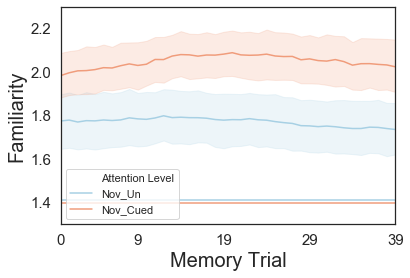

var Sliding Window - Novel Images Only


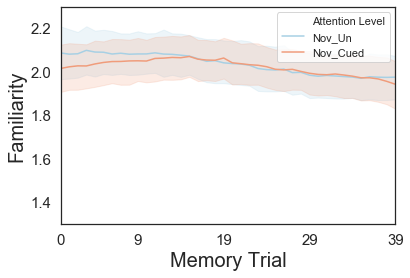

In [26]:
import scipy

# set plot style to white
sb.set_style("white")

# for keys in plot_data (that is, for each experiment)
for key in plot_data.keys():
    
    print(key + ' Sliding Window - Novel Images Only')

    # select the data from that key
    data = plot_data[key]

    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
    ax.set(ylim=(1.3, 2.3))
    ax.set(xlim=(0, 39))

    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)

    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity')

    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])

    # add lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)

    for x in ranges(index):

        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.41, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])

        plt.axhline( y=1.41, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        # plt.axvline(x, .1, .3, color='red')

    plt.xticks([0, 9, 19, 29, 39])

    plt.savefig(label+"novel_time.pdf")
    plt.show()    




### Novel Image Difference Scores

sust Group : Sliding Window - Novel Images Only
slope = 0.002048864003492749
intercept = 0.2390347028602205
p_value = 1.073307749240291e-14



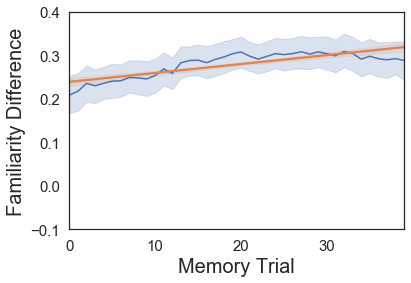

var Group : Sliding Window - Novel Images Only
slope = 0.0015364822393856583
intercept = -0.043379482532148184
p_value = 5.6275197556865e-13



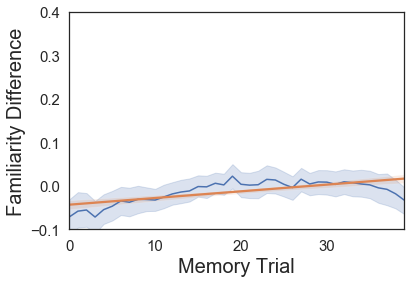

In [27]:
sb.set_style("white")

for key in plot_data.keys():

    print(key + ' Group : Sliding Window - Novel Images Only')

    # exp = plot_data[key][label]

    trial_avs = plot_data[key].groupby(['Trial','Attention Level','UniqueID'], as_index=False).mean()
    trial_avs['Nov_Diffs'] = np.nan

    for s in trial_avs['UniqueID'].unique():
        for t in trial_avs['Trial'].unique():

            first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['UniqueID']==s)]['value'].item()

            second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['UniqueID']==s)]['value'].item()

            difference = first - second

            trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['UniqueID']==s),'Nov_Diffs'] = first - second

    ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
    ax.set(ylim=(-.1, .4))
    ax.set(xlim=(0, 39))

    sb.regplot(x="Trial", y="Nov_Diffs", data=trial_avs, scatter=False)

    trial_av_grp = trial_avs.groupby(['Trial'], as_index=False).mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(trial_avs['Trial'], trial_avs['Nov_Diffs'])

    print('slope = ' + str(slope))
    print('intercept = ' + str(intercept))
    print('p_value = ' + str(p_value))
    print()

    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)

    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity Difference')
    # plt.savefig(exp+"_novel_diff.pdf")

    #print(exp)
    plt.show()


### Uncued Category images


sust: Sliding Window - Novel Images Only


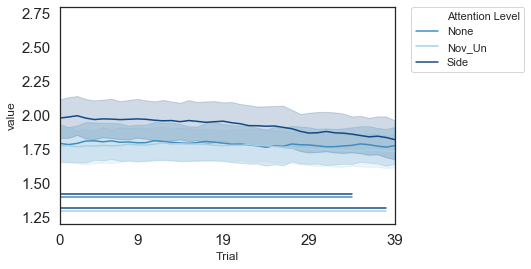

var: Sliding Window - Novel Images Only


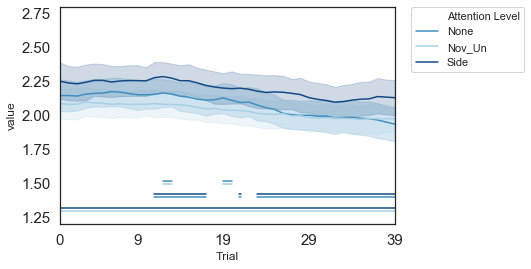

In [28]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    print(key + ': Sliding Window - Novel Images Only')

    data = plot_data[key]

    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.2, 2.8))
    ax.set(xlim=(0, 39))


    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]

    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)

    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)


    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])

        else:
            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])


        # ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Side','None'])

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):
            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
                plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])

            else:
                plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
                plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])

        # ttest at each timepoint #################
        ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)

        # lines w/ sig pval #######################
        index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
        index = set(index)

        for x in ranges(index):

            if x[0] == x[1]:
                x_new_0 = x[0]-.1
                x_new_1 = x[1]+.1

                plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
                plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])

            else:
                plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
                plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])


        plt.xticks([0, 9, 19, 29, 39])

        plt.savefig(label+"_uncued_categories.pdf")
        plt.show()


### Sliding Window - Images in Cued Category

sust: Sliding Window - Novel Images Only


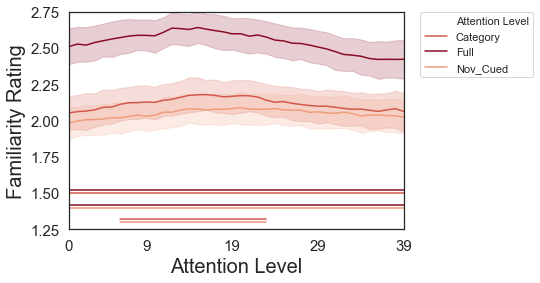

var: Sliding Window - Novel Images Only


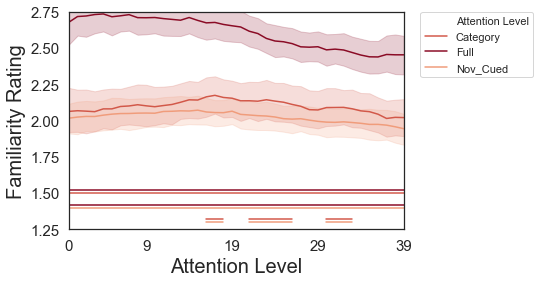

In [29]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    print(key + ': Sliding Window - Novel Images Only')

    data = plot_data[key]

    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))

    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])#, related=False)    

    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Cued') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)

    for x in ranges(index):

        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])

        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])


    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Full'])

    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)

    for x in ranges(index):

        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])


        plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])


    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Full'])

    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)

    for x in ranges(index):

        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])

        plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])

    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)

    plt.xticks([0, 9, 19, 29, 39])

    plt.savefig(label+"cued_categories.pdf")

    plt.show()
    

In [30]:
data_nov

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,...,Attention Button,Rating History,Stimulus Onset,Stimulus End,Attention Probe,Trial,UniqueID,Group,Experiment,Last Cued
0,0,0,150,10,Presentation,3,00926960627Fa_sunapqwoeotxshkukbh.jpg,00076931230fa_sunaafewhewbxmjiurz.jpg,00926960627Fa.jpg,sunapqwoeotxshkukbh.jpg,...,1.0,NaN,1.538592e+09,1.538592e+09,x,0.0,0,1,/sustain,NaN
1,1,1,151,10,Presentation,3,00725941201fa_sunaefgzwiramypjvtd.jpg,00828940307fa_sunahuynahneraqftyz.jpg,00725941201fa.jpg,sunaefgzwiramypjvtd.jpg,...,3.0,NaN,1.538592e+09,1.538592e+09,o,1.0,0,1,/sustain,NaN
2,2,2,152,10,Presentation,3,00089931230fa_sunaagcpoejbuzyvddd.jpg,00730960620fa_sunaekgzpfilgjxpeyq.jpg,00089931230fa.jpg,sunaagcpoejbuzyvddd.jpg,...,1.0,NaN,1.538592e+09,1.538592e+09,x,2.0,0,1,/sustain,NaN
3,3,3,153,10,Presentation,3,00978960627fa_sunbddbivbptlrlauhy.jpg,00265940128fb_sunabkmdplkdbvxriff.jpg,00978960627fa.jpg,sunbddbivbptlrlauhy.jpg,...,3.0,NaN,1.538592e+09,1.538592e+09,o,3.0,0,1,/sustain,NaN
4,4,4,154,10,Presentation,3,00937960627fa_sunaqsolmfydodnakub.jpg,00788941205fa_sunagountlxpzkytsmp.jpg,00937960627fa.jpg,sunaqsolmfydodnakub.jpg,...,1.0,NaN,1.538592e+09,1.538592e+09,x,4.0,0,1,/sustain,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45195,9195,315,395,0,Memory,7,NaN,NaN,NaN,NaN,...,NaN,NaN,1.581101e+09,1.581101e+09,NaN,35.0,112,2,/variabl,Place
45196,9196,316,396,0,Memory,7,NaN,NaN,NaN,NaN,...,NaN,NaN,1.581101e+09,1.581101e+09,NaN,36.0,112,2,/variabl,Place
45197,9197,317,397,0,Memory,7,NaN,NaN,NaN,NaN,...,NaN,NaN,1.581101e+09,1.581101e+09,NaN,37.0,112,2,/variabl,Place
45198,9198,318,398,0,Memory,7,NaN,NaN,NaN,NaN,...,NaN,NaN,1.581101e+09,1.581101e+09,NaN,38.0,112,2,/variabl,Place


In [31]:
# Apply sliding window
window_length = 20

plot_data = {}
    
# Apply sliding window

window_length = 20

exp1_mean_window = apply_window(data_original[(data_original['Experiment']=='/sustain')], window_length)
exp2_mean_window = apply_window(data_original[(data_original['Experiment']=='/variabl')], window_length)
print('finish')

# end up with two dictionaries (one for each exp) each containing two keys ( for groups 1 & 2) 

        
for data,label in zip([exp1_mean_window, exp2_mean_window], ['sust', 'var']):

    plot_data[label] = {}

    #for key in data.keys():

    # average across all trials within each subject
    group = data.reset_index().groupby(['UniqueID','Trial']).mean()

    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['UniqueID','Trial'], value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])

    # assign data to dictionary key
    plot_data[label] = group_melt

    # plotting color key
    palette = sb.color_palette("RdBu", 20)

finish


### Images in Cued Location

sust: Sliding Window - Novel Images Only


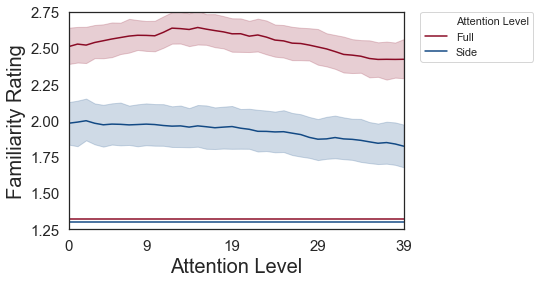

var: Sliding Window - Novel Images Only


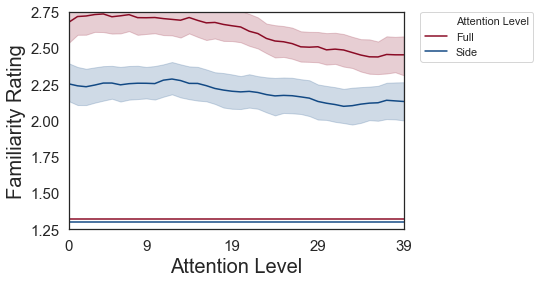

In [32]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    print(key + ': Sliding Window - Novel Images Only')

    data = plot_data[key]


    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))

    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Full','Side'])#, related=False)

    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)


    for x in ranges(index):

        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])

        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])


    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)

    plt.xticks([0, 9, 19, 29, 39])

    plt.savefig(label+"_cued_location.pdf")
    plt.show()
    

### Images in Uncued Location

sust: Sliding Window - Novel Images Only


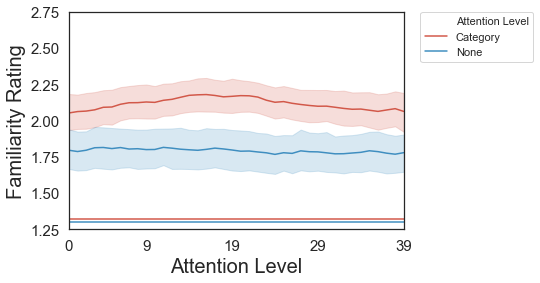

var: Sliding Window - Novel Images Only


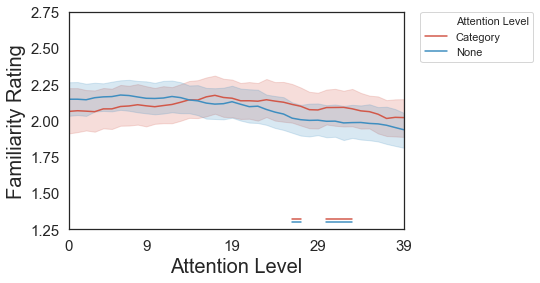

In [33]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    print(key + ': Sliding Window - Novel Images Only')

    data = plot_data[key]

    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category', 'None'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))

    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','None'])#, related=False)    

    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)


    for x in ranges(index):

        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])

        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])



    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)

    plt.xticks([0, 9, 19, 29, 39])

    plt.savefig(label+"_uncued_location.pdf")

    plt.show()


# Gaze Analysis

In [34]:
# gaze = pd.read_csv('../parsed_data/full_gaze.csv')

In [35]:
# gaze.groupby(['Experiment','Group']).mean()

sust: Sliding Window - Novel Images Only


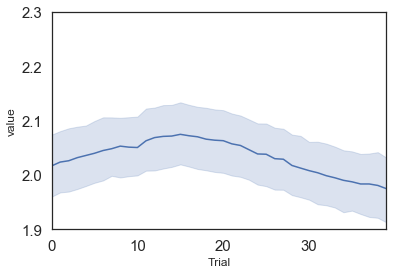

var: Sliding Window - Novel Images Only


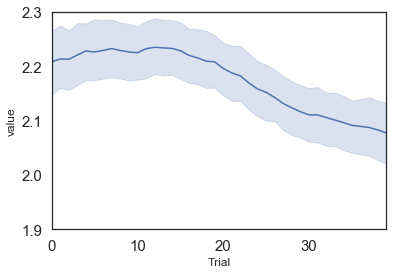

In [46]:
import scipy

sb.set_style("white")

for key in plot_data.keys():
    
    print(key + ': Sliding Window - Novel Images Only')

    data = plot_data[key]

    # plot data
    ax = sb.lineplot(x='Trial',y='value', #hue = 'Attention Level', 
                data = data) #[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
    
    
    ax.set(ylim=(1.9, 2.3))
    ax.set(xlim=(0, 39))
    
    plt.show()
    
    
    
    
                    
                    #palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            #"Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     ax.set(ylim=(1.2, 2.8))
#     ax.set(xlim=(0, 39))


#     # stats test
#     data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]

#     #ttest at each timepoint #################
#     ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)

#     # lines w/ sig pval #######################
#     index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
#     index = set(index)


#     for x in ranges(index):
#         if x[0] == x[1]:
#             x_new_0 = x[0]-.1
#             x_new_1 = x[1]+.1

#             plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
#             plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])

#         else:
#             plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
#             plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])


#         # ttest at each timepoint #################
#         ttest_data = timepoint_ttest(data, ['Side','None'])

#         # lines w/ sig pval #######################
#         index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
#         index = set(index)

#         for x in ranges(index):
#             if x[0] == x[1]:
#                 x_new_0 = x[0]-.1
#                 x_new_1 = x[1]+.1

#                 plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
#                 plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])

#             else:
#                 plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
#                 plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])

#         # ttest at each timepoint #################
#         ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)

#         # lines w/ sig pval #######################
#         index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
#         index = set(index)

#         for x in ranges(index):

#             if x[0] == x[1]:
#                 x_new_0 = x[0]-.1
#                 x_new_1 = x[1]+.1

#                 plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
#                 plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])

#             else:
#                 plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
#                 plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])


#         plt.xticks([0, 9, 19, 29, 39])

#         plt.savefig(label+"_uncued_categories.pdf")
#         plt.show()

In [42]:
plot_data['sust']['UniqueID'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [43]:
plot_data['var']['UniqueID'].unique()

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112])